In [3]:
import pandas as pd
import numpy as np
import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, TrainingArguments, Trainer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset
import os

In [4]:
os.environ["WANDB_DISABLED"] = "true"

In [ ]:
# Define the path to your dataset folder
data_path = './phishing-email-dataset'

# List of all CSV files to combine
csv_files = [
    'CEAS_08.csv',
    'Nazario.csv',
    'Nigerian_Fraud.csv',
    'SpamAssasin.csv'
]

In [11]:
# Load and combine all datasets
dataframes = []
for file in csv_files:
    file_path = os.path.join(data_path, file)
    print(f"Loading {file}...")
    df_temp = pd.read_csv(file_path)

    # Remove receiver column if it exists
    if 'receiver' in df_temp.columns:
        df_temp = df_temp.drop('receiver', axis=1)
        print(f"  - Removed 'receiver' column from {file}")

    print(f"  - Shape: {df_temp.shape}")
    dataframes.append(df_temp)

# Combine all dataframes
df = pd.concat(dataframes, ignore_index=True)
print(f"\nCombined dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")

# Display first few rows
print("\nFirst few rows of combined dataset:")
print(df.head())

# Check for missing values
print("\nMissing values per column:")
print(df.isnull().sum())

# Clean and prepare data
df = df.dropna(subset=['body', 'label'])
print(f"\nDataset shape after removing missing values: {df.shape}")

Loading CEAS_08.csv...
  - Removed 'receiver' column from CEAS_08.csv
  - Shape: (39154, 6)
Loading Nazario.csv...
  - Removed 'receiver' column from Nazario.csv
  - Shape: (1565, 6)
Loading Nigerian_Fraud.csv...
  - Removed 'receiver' column from Nigerian_Fraud.csv
  - Shape: (3332, 6)
Loading SpamAssasin.csv...
  - Removed 'receiver' column from SpamAssasin.csv
  - Shape: (5809, 6)

Combined dataset shape: (49860, 6)
Columns: ['sender', 'date', 'subject', 'body', 'label', 'urls']

First few rows of combined dataset:
                                              sender  \
0                   Young Esposito <Young@iworld.de>   
1                       Mok <ipline's1983@icable.ph>   
2  Daily Top 10 <Karmandeep-opengevl@universalnet...   
3                 Michael Parker <ivqrnai@pobox.com>   
4  Gretchen Suggs <externalsep1@loanofficertool.com>   

                              date  \
0  Tue, 05 Aug 2008 16:31:02 -0700   
1  Tue, 05 Aug 2008 18:31:03 -0500   
2  Tue, 05 Aug 2008 20:28

In [12]:
# Check label distribution
print("\nLabel distribution:")
print(df['label'].value_counts())

texts = df['body'].tolist()
labels = df['label'].tolist()


Label distribution:
label
1    28456
0    21403
Name: count, dtype: int64


In [13]:
# Split the dataset
train_texts, test_texts, train_labels, test_labels = train_test_split(
    texts, labels, test_size=0.2, random_state=42, stratify=labels
)

In [14]:
# Initialize DistilBERT tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Tokenize the data with appropriate truncation and padding
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=512)
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=512)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [15]:
# Create PyTorch Dataset
class EmailDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = EmailDataset(train_encodings, train_labels)
test_dataset = EmailDataset(test_encodings, test_labels)

In [16]:
# Load pretrained DistilBERT model for binary classification
model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    num_labels=2
)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
# Move model to GPU if available
model.to(device)
print(f"Model loaded on: {next(model.parameters()).device}")

Model loaded on: cuda:0


In [ ]:
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,  
    per_device_eval_batch_size=32,   
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=100,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    report_to="none",
    fp16=torch.cuda.is_available(),  
    dataloader_pin_memory=True,      
    dataloader_num_workers=2,        
)

In [19]:
# Define metrics computation
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

In [20]:
# Train the model
print("Training the model...")
trainer.train()

Training the model...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.012000,0.036124,0.990172,0.990161,0.990268,0.990172
2,0.006300,0.019738,0.995387,0.995387,0.995387,0.995387
3,0.000000,0.024814,0.995788,0.995788,0.995788,0.995788


TrainOutput(global_step=7479, training_loss=0.030318708796846602, metrics={'train_runtime': 1555.9863, 'train_samples_per_second': 76.904, 'train_steps_per_second': 4.807, 'total_flos': 1.5851181390575616e+16, 'train_loss': 0.030318708796846602, 'epoch': 3.0})


Evaluating the model...



Evaluation Results:
eval_loss: 0.0197
eval_accuracy: 0.9954
eval_f1: 0.9954
eval_precision: 0.9954
eval_recall: 0.9954
eval_runtime: 34.2106
eval_samples_per_second: 291.4880
eval_steps_per_second: 9.1200
epoch: 3.0000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      4281
           1       1.00      1.00      1.00      5691

    accuracy                           1.00      9972
   macro avg       1.00      1.00      1.00      9972
weighted avg       1.00      1.00      1.00      9972



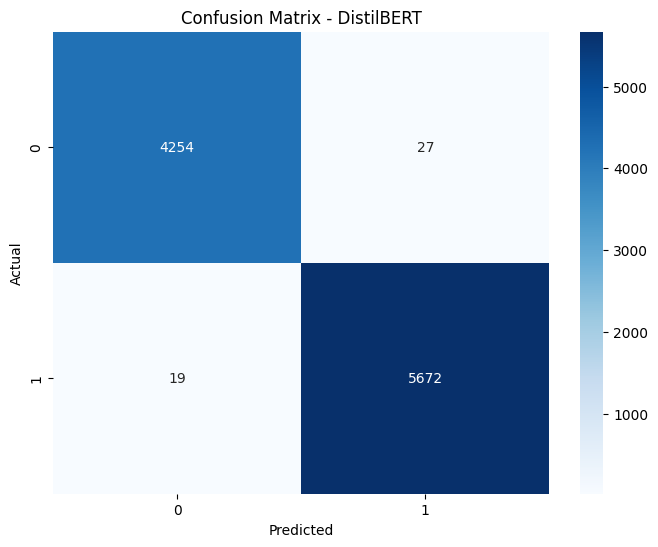


Model saved successfully!


In [21]:
# Evaluate the model
print("\nEvaluating the model...")
eval_results = trainer.evaluate()

print("\nEvaluation Results:")
for key, value in eval_results.items():
    print(f"{key}: {value:.4f}")

# Make predictions
predictions = trainer.predict(test_dataset)
y_pred = np.argmax(predictions.predictions, axis=1)

# Print detailed classification report
from sklearn.metrics import classification_report
print("\nClassification Report:")
print(classification_report(test_labels, y_pred, zero_division=1))

# Visualize confusion matrix
conf_matrix = confusion_matrix(test_labels, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - DistilBERT')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Save the model
model.save_pretrained('./distilbert_phishing_model')
tokenizer.save_pretrained('./distilbert_phishing_model')
print("\nModel saved successfully!")

In [ ]:
# ============================================
# TEST ON SEPARATE TREC_06.csv DATASET
# ============================================

print("\n" + "="*60)
print("TESTING ON TREC_06.csv DATASET")
print("="*60)

# Load TREC_06.csv dataset with error handling
trec_file_path = os.path.join(data_path, 'TREC_06.csv')
print(f"\nLoading {trec_file_path}...")

# Try multiple methods to read the CSV file
try:
    # Method 1: Try with on_bad_lines='skip' (recommended for newer pandas)
    print("Attempting to load with bad line handling...")
    df_trec = pd.read_csv(trec_file_path, on_bad_lines='skip', encoding='utf-8', engine='python')
    print("  - Successfully loaded using on_bad_lines='skip'")
except Exception as e:
    print(f"  - Method 1 failed: {e}")
    try:
        # Method 2: Try with different encoding and engine
        print("Attempting with different encoding...")
        df_trec = pd.read_csv(trec_file_path, encoding='latin-1', engine='python', on_bad_lines='skip')
        print("  - Successfully loaded with latin-1 encoding")
    except Exception as e:
        print(f"  - Method 2 failed: {e}")
        try:
            # Method 3: Try reading in chunks
            print("Attempting to read in chunks...")
            chunk_size = 1000
            chunks = []
            for chunk in pd.read_csv(trec_file_path, chunksize=chunk_size, on_bad_lines='skip',
                                     encoding='utf-8', engine='python', low_memory=False):
                chunks.append(chunk)
            df_trec = pd.concat(chunks, ignore_index=True)
            print(f"  - Successfully loaded in {len(chunks)} chunks")
        except Exception as e:
            print(f"  - Method 3 failed: {e}")
            print("\nPlease check if TREC_06.csv is properly formatted.")
            raise

# Remove receiver column if it exists
if 'receiver' in df_trec.columns:
    df_trec = df_trec.drop('receiver', axis=1)
    print("  - Removed 'receiver' column from TREC_06.csv")

print(f"  - TREC_06 dataset shape: {df_trec.shape}")
print(f"  - Columns: {df_trec.columns.tolist()}")

# Clean data
df_trec = df_trec.dropna(subset=['body', 'label'])

# CRITICAL FIX: Convert float labels to integers
print(f"\nOriginal label dtype: {df_trec['label'].dtype}")
df_trec['label'] = df_trec['label'].astype(int)  # Convert float to int
print(f"Converted label dtype: {df_trec['label'].dtype}")

print(f"  - Shape after removing missing values: {df_trec.shape}")

# Check label distribution
print("\nTREC_06 Label distribution:")
print(df_trec['label'].value_counts())

# Extract texts and labels (ensure labels are integers)
trec_texts = df_trec['body'].tolist()
trec_labels = [int(label) for label in df_trec['label'].tolist()]  # Ensure int type

print(f"\nTREC_06 test samples: {len(trec_texts)}")

# Tokenize TREC_06 data
print("\nTokenizing TREC_06 data...")
trec_encodings = tokenizer(trec_texts, truncation=True, padding=True, max_length=512)

# Create TREC dataset
trec_dataset = EmailDataset(trec_encodings, trec_labels)

# Evaluate on TREC_06 dataset
print("\nEvaluating model on TREC_06 dataset...")
trec_results = trainer.predict(trec_dataset)

# Extract predictions
trec_pred = np.argmax(trec_results.predictions, axis=1)

# Calculate metrics
trec_accuracy = accuracy_score(trec_labels, trec_pred)
trec_precision, trec_recall, trec_f1, _ = precision_recall_fscore_support(
    trec_labels, trec_pred, average='weighted'
)

print("\n" + "="*60)
print("TREC_06 EVALUATION RESULTS")
print("="*60)
print(f"Accuracy:  {trec_accuracy:.4f}")
print(f"Precision: {trec_precision:.4f}")
print(f"Recall:    {trec_recall:.4f}")
print(f"F1-Score:  {trec_f1:.4f}")

# Detailed classification report for TREC_06
print("\nTREC_06 Classification Report:")
print(classification_report(trec_labels, trec_pred, zero_division=1))

# Confusion matrix for TREC_06
trec_conf_matrix = confusion_matrix(trec_labels, trec_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(trec_conf_matrix, annot=True, fmt='d', cmap='Greens')
plt.title('Confusion Matrix - TREC_06 Test Set')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print("\n" + "="*60)
print("COMPARISON: Combined Dataset vs TREC_06")
print("="*60)
print(f"Combined Dataset Test Accuracy: {eval_results['eval_accuracy']:.4f}")
print(f"TREC_06 Test Accuracy:          {trec_accuracy:.4f}")
print(f"Difference:                     {(trec_accuracy - eval_results['eval_accuracy']):.4f}")
print("="*60)

In [ ]:
# ============================================
# SAVE MODEL LOCALLY
# ============================================
local_model_path = './distilbert_phishing_model'

print("\n" + "="*60)
print("SAVING MODEL")
print("="*60)

# Create the directory if it doesn't exist
os.makedirs(local_model_path, exist_ok=True)

print(f"\nSaving model to: {local_model_path}")

try:
    model.save_pretrained(local_model_path)
    tokenizer.save_pretrained(local_model_path)
    print("✓ Model and tokenizer saved successfully!")
except Exception as e:
    print(f"✗ Error saving model: {e}")

# Verify the files were saved
if os.path.exists(local_model_path):
    saved_files = os.listdir(local_model_path)
    print(f"\nFiles saved ({len(saved_files)} files):")
    for file in saved_files:
        file_size = os.path.getsize(os.path.join(local_model_path, file)) / (1024 * 1024)
        print(f"  - {file} ({file_size:.2f} MB)")
    
    print(f"\n✓ Model is now saved locally at: {local_model_path}")
else:
    print("\n✗ Failed to save model!")

# Save training results summary
summary_path = os.path.join(local_model_path, 'training_summary.txt')
with open(summary_path, 'w') as f:
    f.write("="*60 + "\n")
    f.write("PHISHING EMAIL DETECTION MODEL - TRAINING SUMMARY\n")
    f.write("="*60 + "\n\n")
    f.write(f"Model: DistilBERT\n")
    f.write(f"Training Date: {pd.Timestamp.now()}\n\n")
    f.write(f"Combined Dataset Test Accuracy: {eval_results['eval_accuracy']:.4f}\n")
    f.write(f"Combined Dataset Test F1-Score: {eval_results['eval_f1']:.4f}\n")
    f.write(f"Combined Dataset Test Precision: {eval_results['eval_precision']:.4f}\n")
    f.write(f"Combined Dataset Test Recall: {eval_results['eval_recall']:.4f}\n\n")
    f.write(f"Total Training Samples: {len(train_texts)}\n")
    f.write(f"Total Testing Samples: {len(test_texts)}\n")
    f.write("="*60 + "\n")

print(f"✓ Training summary saved to: {summary_path}")

# Save combined dataset for future use
combined_csv_path = os.path.join(data_path, 'combined_dataset.csv')
df.to_csv(combined_csv_path, index=False)
print(f"✓ Combined dataset saved to: {combined_csv_path}")

print("\n" + "="*60)
print("TRAINING COMPLETE!")
print("="*60)
print(f"\nModel location: {local_model_path}")
print(f"Results location: ./results/")
print(f"Logs location: ./logs/")
print("\nYou can now use this model for inference or deploy it as an API.")